In [1]:
import sys  
sys.path.insert(0, '../')

import lightgbm as lgbm
import numpy as np
import os
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from feature_extraction import loan_struct_reader

from feature_extraction.loan_concatenator import LoanConcatenator
from feature_extraction.loan_markuper import LoanMarkuper
from feature_extraction.loan_options_maker import LoanOptionsMaker
from feature_extraction.loan_struct_reader import LoanStructReader

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt

In [2]:
step = 5

In [3]:
def iterative_ds(params, X_train, X_test, y_train, y_test, verbose=False):
    # initialize model
    ss = step
    estimator = None
    
    if 'max_depth' in params: params['max_depth'] = int(params['max_depth'])
    if 'num_leaves' in params: params['num_leaves'] = int(params['num_leaves'])
    num_boost_round = int(params.pop('num_boost_round', 5))
    
    train_info = {'train_mae':[], 'test_mae':[]}
    
    for iteration, x in enumerate(range(0, X_train.shape[0] - ss, ss)):
        indices = list(range(x, x + ss))

        estimator = lgbm.train(params,
                               init_model=estimator,
                               train_set=lgbm.Dataset(X_train[indices], y_train[indices]),
                               keep_training_booster=True,
                               num_boost_round=num_boost_round)

        mae = mean_absolute_error(y_test, estimator.predict(X_test))
        if iteration % 5 == 0 and verbose:
            print('iteration: {} mae: {}'.format(iteration, mae))
        
        train_info['train_mae'].append(np.mean(np.abs(y_train[:x + ss] - estimator.predict(X_train[:x + ss])) / y_train[:x + ss]))
        train_info['test_mae'].append(np.mean(np.abs(y_test - estimator.predict(X_test)) / y_test))
    return train_info

In [4]:
ROOT = os.path.dirname(os.getcwd())
FILES_DIR = os.path.join(ROOT, "json_augmented")
MARKUPFILE = os.path.join(FILES_DIR, r"markupdict0-2000.pckl")

In [5]:
# read etalon

json_example_path = os.path.join(ROOT, r"json_real", r"sample_1.json")
struct, original_options = LoanStructReader().Read(json_example_path, returnOptions=True)

In [6]:
# generate fake train_data

markuper = LoanMarkuper()
optionsMaker = LoanOptionsMaker()
markupdict = {}
for i in range(0, 300):
    options = optionsMaker.Make(original_options)

    js = LoanConcatenator(struct, options, {}).Parse()
    name = "sample_{}.json".format(i)
    LoanConcatenator.Save(js, os.path.join(ROOT, r"json_augmented", name))
    markupdict[name] = markuper.MarkupLoan(js)

In [7]:
# markup generated train_data

X, y = [], []
for file in os.listdir(FILES_DIR):
    if file.find("markupdict") != -1:
        with open(os.path.join(FILES_DIR, file), 'rb') as f:
            markupdict = pickle.load(f)
    else:
        _, options = loan_struct_reader.LoanStructReader().Read(os.path.join(FILES_DIR, file), returnOptions=True)
        X.append(options['irOptions_curve'])
        y.append(markupdict[file])
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Подбор гиперпараметров

In [8]:
base_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'is_unbalance': False,
    'seed': 42,
    'verbosity': -1,
    'min_data': 1,
    'min_data_in_bin': 1
}

In [9]:
def modelFitter(num_boost_round, learning_rate, colsample_bytree, subsample, max_depth, num_leaves):   
    params = copy.copy(base_params)
    params['num_boost_round'] = num_boost_round
    params['learning_rate'] = learning_rate
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['max_depth'] = max_depth
    params['num_leaves'] = num_leaves
    
    info = iterative_ds(params, X_train, X_test, y_train, y_test, verbose=False)

    return -info['test_mae'][-1]

# Bounded region of parameter space
pbounds = {'num_boost_round': (3, 25), 'learning_rate': (0.01, 0.5), 'colsample_bytree': (0.8, 1.0), 'subsample': (0.8,1.0), 'max_depth': (2,5), 'num_leaves': (24, 45)}

optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=pbounds,
    random_state=1)

optimizer.maximize(init_points=10,n_iter=10)  #n_iter=bayesian, init_points=random

|   iter    |  target   | colsam... | learni... | max_depth | num_bo... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.02625  |  0.8834   |  0.363    |  2.0      |  9.651    |  27.08    |  0.8185   |
|  2        | -0.01772  |  0.8373   |  0.1793   |  3.19     |  14.85    |  32.8     |  0.937    |
|  3        | -0.008391 |  0.8409   |  0.4403   |  2.082    |  17.75    |  32.76    |  0.9117   |
|  4        | -0.03169  |  0.8281   |  0.1071   |  4.402    |  24.3     |  30.58    |  0.9385   |
|  5        | -0.01593  |  0.9753   |  0.4484   |  2.255    |  3.859    |  27.57    |  0.9756   |
|  6        | -0.01985  |  0.8197   |  0.2163   |  4.874    |  14.73    |  38.53    |  0.8631   |
|  7        | -0.01987  |  0.9373   |  0.419    |  2.055    |  19.5     |  44.77    |  0.9496   |
|  8        | -0.0192   |  0.8561   |  0.3967   |  2.31     |  12.85    |  43.08    |  0.8587   |
|  9        | -0.005

In [10]:
optimizer.max['params']

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 2.0,
 'num_boost_round': 21.253363387695376,
 'num_leaves': 26.572531081395677,
 'subsample': 0.8}

# Обучение лучшей модели.

In [11]:
# make iterative learning

optim_params = copy.copy(base_params)
optim_params.update(optimizer.max['params'])

# works
train_info = iterative_ds(optim_params, X_train, X_test, y_train, y_test, verbose=True)

iteration: 0 mae: 161180.6368285705
iteration: 5 mae: 122553.92805605104
iteration: 10 mae: 118036.1645038149
iteration: 15 mae: 101097.15533205912
iteration: 20 mae: 90609.6723934248
iteration: 25 mae: 79593.77875640552
iteration: 30 mae: 78728.44426727295
iteration: 35 mae: 73506.26467152844


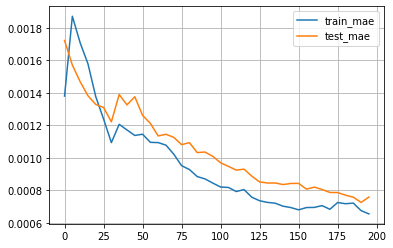

In [12]:
plt.plot(np.arange(len(train_info['train_mae'])) * step, train_info['train_mae'], label='train_mae')
plt.plot(np.arange(len(train_info['test_mae'])) * step, train_info['test_mae'], label='test_mae')
plt.legend()
plt.grid()